# Matting预测

输入原始图像和trimap三值图，进行Matting预测，输出阿尔法图像。

同济子豪兄 2023-2-27

## 进入 MMEditing 主目录

In [1]:
import os
os.chdir('mmediting')

## 导入工具包

In [2]:
import mmcv
from mmedit.edit import MMEdit

import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

## 列出所有IndexNet算法模型

In [3]:
# List all available IndexNet models
!mim search mmedit --model indexnet

--------------------------------------------------------------------------------
config id: indexnet_mobv2_1xb16-78k_comp1k
composition-1k/conn                                                                              
composition-1k/grad                                                                              
composition-1k/mse                                                                               
composition-1k/sad                                                                               
config                                                                                           
model                                                                                            
paper                                                                                            
readme                                                                                           
weight                                                                                      

## 下载指定模型`config`配置文件和`checkpoint`权重文件

In [7]:
# !mkdir -p checkpoint
# !mim download mmedit --config indexnet_mobv2_1x16_78k_comp1k --dest checkpoints

In [4]:
!mim download mmedit --config indexnet_mobv2_1xb16-78k_comp1k
!wget https://download.openmmlab.com/mmediting/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth -P checkpoint

processing indexnet_mobv2_1xb16-78k_comp1k...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MiB 6.3 MB/s eta 0:00:0000:0100:01
Successfully downloaded indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth to /home/featurize/.cache/mim
Successfully dumped indexnet_mobv2_1xb16-78k_comp1k.py to /home/featurize/.cache/mim
--2023-03-06 18:29:06--  https://download.openmmlab.com/mmediting/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 24079143 (23M) [application/octet-stream]
正在保存至: “checkpoint/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth”

indexnet_mobv2_1x16 100%[===================>]  22.96M  19.0MB/s    用时 1.2s    

2023-03-06 18:29:08 (19.0 MB/s) - 已保存 “checkpoint/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth” [24079143/24079143])



## 初始化模型

In [5]:
from mmedit.apis import matting_inference, init_model

# config配置文件路径
config = 'configs/indexnet/indexnet_mobv2_1xb16-78k_comp1k.py'

# checkpoint权重文件路径
checkpoint = 'checkpoint/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth' 

#初始化模型
model = init_model(config, checkpoint, device='cuda:0')

Loads checkpoint by local backend from path: checkpoint/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth


## 载入原始图片

In [7]:
img_path = 'data/matting/GT05.jpg'

## 展示原始图片

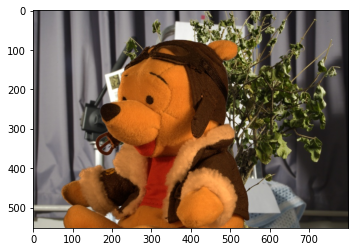

In [8]:
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [9]:
img_bgr.shape

(552, 800, 3)

## 载入trimap图片

In [12]:
trimap_path = 'data/matting/GT05_trimap.jpg'

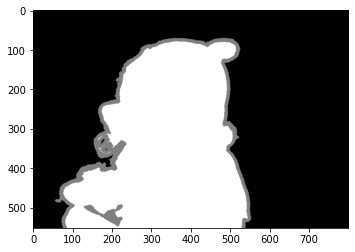

In [13]:
trimap_bgr = cv2.imread(trimap_path)
trimap_rgb = cv2.cvtColor(trimap_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(trimap_rgb)
plt.show()

In [14]:
trimap_bgr.shape

(552, 800, 3)

In [15]:
np.unique(trimap_bgr)

array([  0, 128, 255], dtype=uint8)

trimap图是png格式的单通道图片（如果是三通道，每个通道都相同）。

包含三类像素值，0、128、256，

分别表示：前景、未知、背景

trimap可以认为是一个粗略的标注，模型基于 trimap 的范围进行更细粒度的细化。

## 运行预测

In [16]:
pred_alpha = matting_inference(model, img_path, trimap_path)

/environment/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [17]:
pred_alpha.shape

(552, 800)

In [18]:
np.unique(pred_alpha)

array([  0,   1, 255], dtype=uint8)

## 可视化预测结果

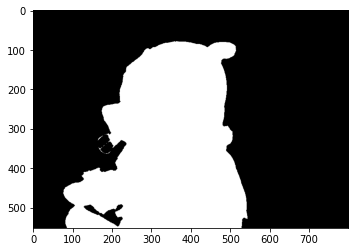

In [19]:
plt.imshow(pred_alpha, cmap=plt.get_cmap('gray'))
plt.show()

## 可视化前景（白色为前景）

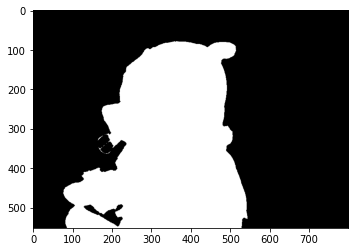

In [20]:
plt.imshow(pred_alpha==255, cmap=plt.get_cmap('gray'))
plt.show()

## 可视化背景（白色为背景）

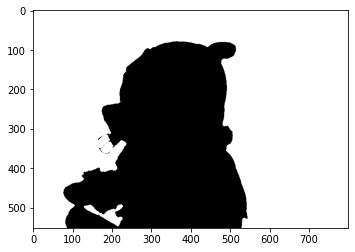

In [21]:
plt.imshow(pred_alpha==0, cmap=plt.get_cmap('gray'))
plt.show()